In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

2023-05-02 01:48:11.739297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 01:48:11.822924: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-02 01:48:12.163941: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-02 01:48:12.163976: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [3]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [4]:
features_train, features_test, targets_train, targets_test = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 42)


In [5]:
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

In [6]:
# Pytorch train and test TensorDataset
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

In [7]:
len(features_train)

48000

In [8]:
# Hyper Parameters
# batch_size, epoch and iteration
LR = 0.001
batch_size = 480
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)
num_epochs

100

In [9]:
# Pytorch DataLoader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)


In [10]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution 1 , input_shape=(1,28,28)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0) #output_shape=(16,24,24)
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,12,12)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #output_shape=(32,8,8)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,4,4)
        # Fully connected 1 ,#input_shape=(32*4*4)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        out = self.maxpool1(out)
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2 
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        return out

In [11]:
model = CNN_Model()
print(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
input_shape = (-1,1,28,28)

CNN_Model(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)
cuda:0


In [12]:
def fit_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader):
    # Traning the Model
    #history-like list for store loss & acc value
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    for epoch in range(num_epochs):
        #training model & store loss & acc / epoch
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_loader):
            # 1.Define variables
            train = Variable(images.view(input_shape)).to(device)
            labels = Variable(labels).to(device)
            # 2.Clear gradients
            optimizer.zero_grad()
            # 3.Forward propagation
            outputs = model(train.to(device))
            # 4.Calculate softmax and cross entropy loss
            train_loss = loss_func(outputs, labels)
            # 5.Calculate gradients
            train_loss.backward()
            # 6.Update parameters
            optimizer.step()
            # 7.Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            # 8.Total number of labels
            total_train += len(labels)
            # 9.Total correct predictions
            correct_train += (predicted == labels).float().sum()
        #10.store val_acc / epoch
        train_accuracy = 100 * correct_train / float(total_train)
        training_accuracy.append(train_accuracy)
        # 11.store loss / epoch
        training_loss.append(train_loss.data)

        #evaluate model & store loss & acc / epoch
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:
            # 1.Define variables
            test = Variable(images.view(input_shape)).to(device)
            # 2.Forward propagation
            outputs = model(test).to(device)
            labels = labels.to(device)
            # 3.Calculate softmax and cross entropy loss
            val_loss = loss_func(outputs, labels)
            # 4.Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            # 5.Total number of labels
            total_test += len(labels)
            # 6.Total correct predictions
            correct_test += (predicted == labels).float().sum()
        #6.store val_acc / epoch
        val_accuracy = 100 * correct_test / float(total_test)
        validation_accuracy.append(val_accuracy)
        # 11.store val_loss / epoch
        validation_loss.append(val_loss.data)
        print('Train Epoch: {}/{} Traing_Loss: {} Traing_acc: {:.6f}% Val_Loss: {} Val_accuracy: {:.6f}%'.format(epoch+1, num_epochs, train_loss.data, train_accuracy, val_loss.data, val_accuracy))
    return training_loss, training_accuracy, validation_loss, validation_accuracy

In [13]:
training_loss, training_accuracy, validation_loss, validation_accuracy = fit_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader)

Train Epoch: 1/100 Traing_Loss: 0.22628216445446014 Traing_acc: 80.945831% Val_Loss: 0.2694840729236603 Val_accuracy: 92.808334%
Train Epoch: 2/100 Traing_Loss: 0.20363612473011017 Traing_acc: 94.687500% Val_Loss: 0.09139572829008102 Val_accuracy: 95.908333%
Train Epoch: 3/100 Traing_Loss: 0.08275874704122543 Traing_acc: 96.412498% Val_Loss: 0.1101677417755127 Val_accuracy: 97.049995%
Train Epoch: 4/100 Traing_Loss: 0.09061586856842041 Traing_acc: 97.268745% Val_Loss: 0.07352528721094131 Val_accuracy: 97.474998%
Train Epoch: 5/100 Traing_Loss: 0.05776755511760712 Traing_acc: 97.645836% Val_Loss: 0.09760915488004684 Val_accuracy: 97.866669%
Train Epoch: 6/100 Traing_Loss: 0.0901595875620842 Traing_acc: 98.081245% Val_Loss: 0.06229781731963158 Val_accuracy: 98.016663%
Train Epoch: 7/100 Traing_Loss: 0.03238007798790932 Traing_acc: 98.227081% Val_Loss: 0.06611640006303787 Val_accuracy: 98.291664%
Train Epoch: 8/100 Traing_Loss: 0.04870080575346947 Traing_acc: 98.427086% Val_Loss: 0.071076

In [14]:
model = CNN_Model()
print(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
input_shape = (-1,1,28,28)

CNN_Model(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)
cuda:0


In [15]:
training_loss_adamW, training_accuracy_adamW, validation_loss_adamW, validation_accuracy_adamW = fit_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader)

Train Epoch: 1/100 Traing_Loss: 0.22942152619361877 Traing_acc: 80.702080% Val_Loss: 0.22690673172473907 Val_accuracy: 93.608330%
Train Epoch: 2/100 Traing_Loss: 0.09974194318056107 Traing_acc: 95.004166% Val_Loss: 0.12492987513542175 Val_accuracy: 96.275002%
Train Epoch: 3/100 Traing_Loss: 0.10787533968687057 Traing_acc: 96.770836% Val_Loss: 0.09062693268060684 Val_accuracy: 97.308334%
Train Epoch: 4/100 Traing_Loss: 0.08468674123287201 Traing_acc: 97.441666% Val_Loss: 0.09155774116516113 Val_accuracy: 97.866669%
Train Epoch: 5/100 Traing_Loss: 0.08071108907461166 Traing_acc: 97.920830% Val_Loss: 0.05668443441390991 Val_accuracy: 97.924995%
Train Epoch: 6/100 Traing_Loss: 0.07473013550043106 Traing_acc: 98.254166% Val_Loss: 0.04647763818502426 Val_accuracy: 98.199997%
Train Epoch: 7/100 Traing_Loss: 0.04730265587568283 Traing_acc: 98.372917% Val_Loss: 0.059434082359075546 Val_accuracy: 98.408333%
Train Epoch: 8/100 Traing_Loss: 0.05850920453667641 Traing_acc: 98.487495% Val_Loss: 0.07

In [16]:
model = CNN_Model()
print(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.01)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
input_shape = (-1,1,28,28)

CNN_Model(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)
cuda:0


In [17]:
training_loss_L2, training_accuracy_L2, validation_loss_L2, validation_accuracy_L2 = fit_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader)

Train Epoch: 1/100 Traing_Loss: 0.2926076352596283 Traing_acc: 81.877083% Val_Loss: 0.2984883487224579 Val_accuracy: 92.599998%
Train Epoch: 2/100 Traing_Loss: 0.13633649051189423 Traing_acc: 93.968750% Val_Loss: 0.1832679808139801 Val_accuracy: 95.441666%
Train Epoch: 3/100 Traing_Loss: 0.09739960730075836 Traing_acc: 95.608330% Val_Loss: 0.11805874854326248 Val_accuracy: 96.366669%
Train Epoch: 4/100 Traing_Loss: 0.10838505625724792 Traing_acc: 96.404167% Val_Loss: 0.1029934510588646 Val_accuracy: 96.716667%
Train Epoch: 5/100 Traing_Loss: 0.14231419563293457 Traing_acc: 96.643745% Val_Loss: 0.1004195585846901 Val_accuracy: 97.091667%
Train Epoch: 6/100 Traing_Loss: 0.14521336555480957 Traing_acc: 97.033333% Val_Loss: 0.0642029196023941 Val_accuracy: 97.449997%
Train Epoch: 7/100 Traing_Loss: 0.08457840234041214 Traing_acc: 97.197914% Val_Loss: 0.09297128021717072 Val_accuracy: 97.366669%
Train Epoch: 8/100 Traing_Loss: 0.11034782230854034 Traing_acc: 97.250000% Val_Loss: 0.054017476

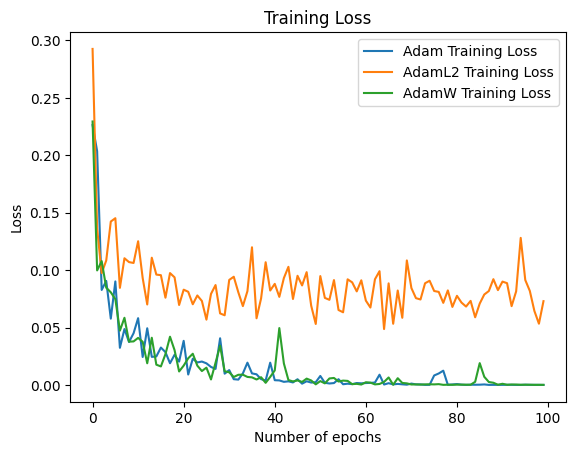

In [18]:
# visualization
plt.plot(range(num_epochs), np.array(torch.tensor(training_loss, device="cpu")), label='Adam Training Loss')
plt.plot(range(num_epochs), np.array(torch.tensor(training_loss_L2, device="cpu")), label='AdamL2 Training Loss')
plt.plot(range(num_epochs), np.array(torch.tensor(training_loss_adamW, device="cpu")), label='AdamW Training Loss')


plt.title('Training Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


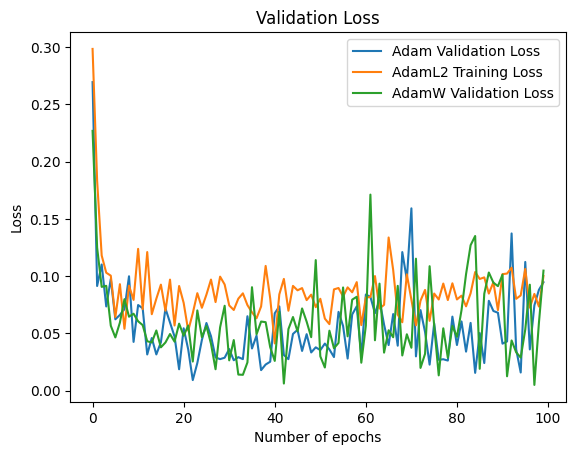

In [19]:
# visualization
plt.plot(range(num_epochs), np.array(torch.tensor(validation_loss, device="cpu")), label='Adam Validation Loss')
plt.plot(range(num_epochs), np.array(torch.tensor(validation_loss_L2, device="cpu")), label='AdamL2 Training Loss')
plt.plot(range(num_epochs), np.array(torch.tensor(validation_loss_adamW, device="cpu")) , label='AdamW Validation Loss')

plt.title('Validation Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


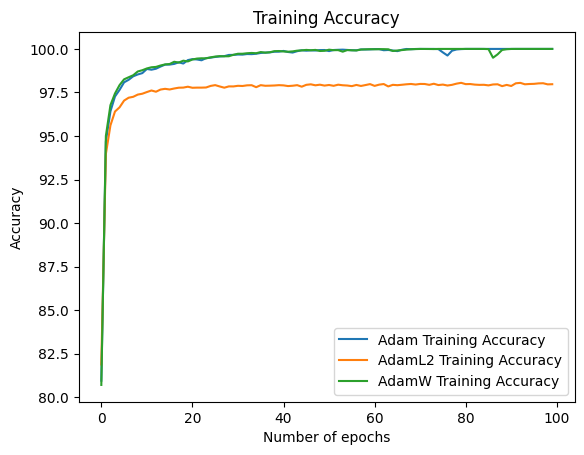

In [20]:
#plt.plot(range(num_epochs), training_accuracy, 'b-', label='Training_accuracy')
#plt.plot(range(num_epochs), validation_accuracy, 'g-', label='Validation_accuracy')

plt.plot(range(num_epochs), np.array(torch.tensor(training_accuracy, device="cpu")), label='Adam Training Accuracy')
plt.plot(range(num_epochs), np.array(torch.tensor(training_accuracy_L2, device="cpu")), label='AdamL2 Training Accuracy')
plt.plot(range(num_epochs), np.array(torch.tensor(training_accuracy_adamW, device="cpu")), label='AdamW Training Accuracy')


plt.title('Training Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

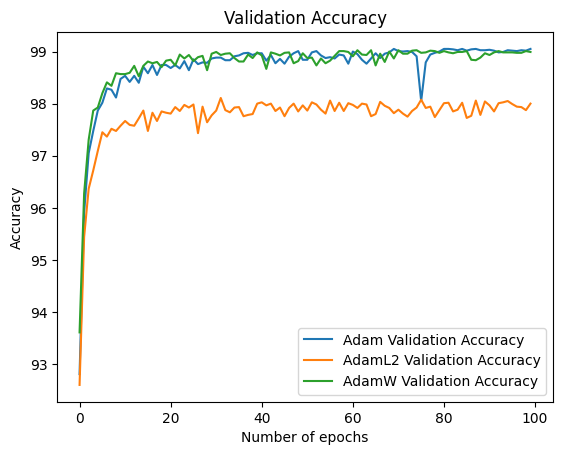

In [21]:
plt.plot(range(num_epochs), np.array(torch.tensor(validation_accuracy, device="cpu")), label='Adam Validation Accuracy')
plt.plot(range(num_epochs), np.array(torch.tensor(validation_accuracy_L2, device="cpu")), label='AdamL2 Validation Accuracy')
plt.plot(range(num_epochs), np.array(torch.tensor(validation_accuracy_adamW, device="cpu")), label='AdamW Validation Accuracy')

plt.title('Validation Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()